In [1]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
from sklearn.metrics import r2_score
import pickle
from tqdm import tqdm
import csv
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('small')

#Import decoder functions
from Neural_Decoding.decoders import KalmanFilterDecoder

In [2]:
#Get Data in the correct format
#enter the folder where the data is
folder='../SR-Task/preprocessed_data/'

with open(folder+'all_data_SR.pickle','rb') as f:
    #If using python 3
    M1, PMd, M1_PMd,pos_binned,vels_binned=pickle.load(f,encoding='latin1') 


In [3]:
## Do preprocessing and run the decoder for different neural data sets
#neural_data_combined = [M1, PMd, M1_PMd]
neural_data_combined = [M1, M1_PMd]
#kinematics = [pos_binned, vels_binned]

# User 
lag=0 #What time bin of spikes should be used relative to the output
#(lag=-1 means use the spikes 1 bin before the output)

# variable which stores R^2 values
R2 = np.empty((2,2))
# index variable
for i in tqdm(range(2)):
    neural_data = neural_data_combined[i]
    
    # Formatting for KF
    # Input
    #The covariate is simply the matrix of firing rates for all neurons over time
    X_kf=neural_data
    # Output
    #The final output covariates include position, velocity, and acceleration
    y_kf=np.concatenate((pos_binned,vels_binned),axis=1)
    
    # Take into account lag (if it applies to the analysis)
    num_examples=X_kf.shape[0]

    #Re-align data to take lag into account
    if lag<0:
        y_kf=y_kf[-lag:,:]
        X_kf=X_kf[0:num_examples+lag,:]
    if lag>0:
        y_kf=y_kf[0:num_examples-lag,:]
        X_kf=X_kf[lag:num_examples,:]
        
    # Splitting data into training/testing/validation sets
    #Set what part of data should be part of the training/testing/validation sets
    training_range=[0, 0.7]
    testing_range=[0.7, 0.85]
    valid_range=[0.85,1]
    
    # Split data for KF
    #Number of examples after taking into account bins removed for lag alignment
    num_examples_kf=X_kf.shape[0]

    #Note that each range has a buffer of 1 bin at the beginning and end
    #This makes it so that the different sets don't include overlapping data
    training_set=np.arange(int(np.round(training_range[0]*num_examples_kf))+1,int(np.round(training_range[1]*num_examples_kf))-1)
    testing_set=np.arange(int(np.round(testing_range[0]*num_examples_kf))+1,int(np.round(testing_range[1]*num_examples_kf))-1)
    valid_set=np.arange(int(np.round(valid_range[0]*num_examples_kf))+1,int(np.round(valid_range[1]*num_examples_kf))-1)

    #Get training data
    X_kf_train=X_kf[training_set,:]
    y_kf_train=y_kf[training_set,:]

    #Get testing data
    X_kf_test=X_kf[testing_set,:]
    y_kf_test=y_kf[testing_set,:]

    #Get validation data
    X_kf_valid=X_kf[valid_set,:]
    y_kf_valid=y_kf[valid_set,:]
    
    #  Preprocessing: Normalization and zero-centering
    #Z-score inputs 
    X_kf_train_mean=np.nanmean(X_kf_train,axis=0)
    X_kf_train_std=np.nanstd(X_kf_train,axis=0)
    X_kf_train=(X_kf_train-X_kf_train_mean)/X_kf_train_std
    X_kf_test=(X_kf_test-X_kf_train_mean)/X_kf_train_std
    X_kf_valid=(X_kf_valid-X_kf_train_mean)/X_kf_train_std

    #Zero-center outputs
    y_kf_train_mean=np.mean(y_kf_train,axis=0)
    y_kf_train=y_kf_train-y_kf_train_mean
    y_kf_test=y_kf_test-y_kf_train_mean
    y_kf_valid=y_kf_valid-y_kf_train_mean
    
    # Run the decoders
    # 1. Kalman filter
    #Declare model
    model_kf=KalmanFilterDecoder(C=1) #There is one optional parameter that is set to the default in this example (see ReadMe)

    #Fit model
    model_kf.fit(X_kf_train,y_kf_train)

    #Get predictions
    y_valid_predicted_kf=model_kf.predict(X_kf_valid,y_kf_valid)
    
    if i == 0:
        predictions = y_valid_predicted_kf
    else:
        predictions = [predictions, y_valid_predicted_kf]
    
    R2_pos = r2_score(y_kf_valid[:,0:2],y_valid_predicted_kf[:,0:2], multioutput='variance_weighted')
    R2_vel = r2_score(y_kf_valid[:,2:4],y_valid_predicted_kf[:,2:4], multioutput='variance_weighted')
    
    print(R2_pos, R2_vel)
    R2[i,:] = R2_pos, R2_vel

 50%|██████████████████████████████████████████                                          | 1/2 [00:01<00:01,  1.44s/it]

0.6044223850189259 0.5688264812293269


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]

0.6545592573818615 0.5977990302810479


In [4]:
R2 = np.around(R2, 3)
print(R2)

[[0.604 0.569]
 [0.655 0.598]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


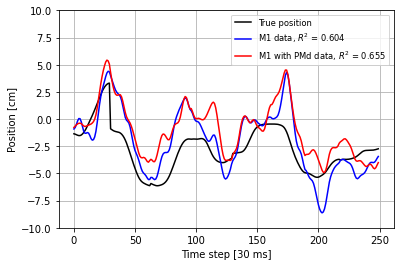

In [9]:
fig_x_kf=plt.figure()
plt.plot(y_kf_valid[1050:1300,0],'k',label="True position")
plt.plot(predictions[0][1050:1300,0],'b',label="M1 data, $R^2$ = " + str(np.squeeze(R2[0,0])))
plt.plot(predictions[1][1050:1300,0],'r',label="M1 with PMd data, $R^2$ = " + str(np.squeeze(R2[1,0])))
plt.grid()
#plt.plot(y_valid_predicted_wf[-1-38:,0]+y_train_mean[0],'r', label="Predicted velocity")
plt.legend(loc="upper right", prop = fontP)
plt.xlabel("Time step [30 ms]")
plt.ylabel("Position [cm]")
plt.ylim([-10, 10])
plt.savefig('figures/SR_example_predictions/KF_SR_pos_X.eps', format='eps')
plt.savefig('figures/SR_example_predictions/KF_SR_pos_X.png')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


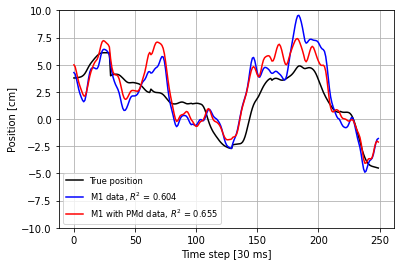

In [12]:
fig_x_kf=plt.figure()
plt.plot(y_kf_valid[1050:1300,1],'k',label="True position")
plt.plot(predictions[0][1050:1300,1],'b',label="M1 data, $R^2$ = " + str(np.squeeze(R2[0,0])))
plt.plot(predictions[1][1050:1300,1],'r',label="M1 with PMd data, $R^2$ = " + str(np.squeeze(R2[1,0])))
plt.grid()
#plt.plot(y_valid_predicted_wf[-1-38:,0]+y_train_mean[0],'r', label="Predicted velocity")
plt.legend(loc="lower left", prop = fontP)
plt.xlabel("Time step [30 ms]")
plt.ylabel("Position [cm]")
plt.ylim([-10, 10])
plt.savefig('figures/SR_example_predictions/KF_SR_pos_Y.eps', format='eps')
plt.savefig('figures/SR_example_predictions/KF_SR_pos_Y.png')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


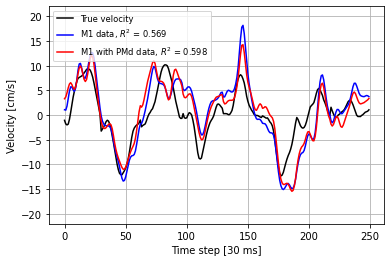

In [13]:
fig_x_kf=plt.figure()
plt.plot(y_kf_valid[1050:1300,2],'k',label="True velocity")
plt.plot(predictions[0][1050:1300,2],'b',label="M1 data, $R^2$ = " + str(np.squeeze(R2[0,1])))
plt.plot(predictions[1][1050:1300,2],'r',label="M1 with PMd data, $R^2$ = " + str(np.squeeze(R2[1,1])))
plt.grid()

plt.legend(loc="best", prop = fontP)
plt.xlabel("Time step [30 ms]")
plt.ylabel("Velocity [cm/s]")
plt.ylim([-22, 22])
plt.savefig('figures/SR_example_predictions/KF_SR_vel_X.eps', format='eps')
plt.savefig('figures/SR_example_predictions/KF_SR_vel_X.png')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


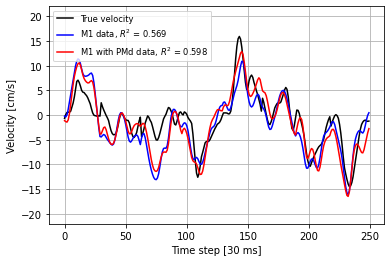

In [15]:
fig_x_kf=plt.figure()
plt.plot(y_kf_valid[1050:1300,3],'k',label="True velocity")
plt.plot(predictions[0][1050:1300,3],'b',label="M1 data, $R^2$ = " + str(np.squeeze(R2[0,1])))
plt.plot(predictions[1][1050:1300,3],'r',label="M1 with PMd data, $R^2$ = " + str(np.squeeze(R2[1,1])))
plt.grid()
#plt.plot(y_valid_predicted_wf[-1-38:,0]+y_train_mean[0],'r', label="Predicted velocity")
plt.legend(loc="best", prop = fontP)
plt.xlabel("Time step [30 ms]")
plt.ylabel("Velocity [cm/s]")
plt.ylim([-22, 22])
plt.savefig('figures/SR_example_predictions/KF_SR_vel_Y.eps', format='eps')
plt.savefig('figures/SR_example_predictions/KF_SR_vel_Y.png')
plt.show()